In [1]:
import wfdb
import gudhi

In [2]:
record = wfdb.rdrecord(record_name='data/mitdb/1.0.0/100', sampfrom=1000 ,sampto=2000)

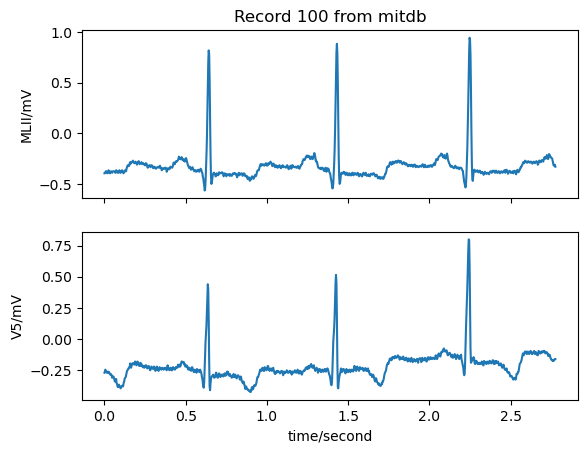

In [3]:
wfdb.plot_wfdb(record=record, title='Record 100 from mitdb')

In [4]:
ecg_data = record.p_signal

In [5]:
print(ecg_data)

[[-0.395 -0.27 ]
 [-0.395 -0.26 ]
 [-0.385 -0.245]
 ...
 [-0.32  -0.165]
 [-0.31  -0.16 ]
 [-0.33  -0.16 ]]


In [7]:
rips_complex = gudhi.RipsComplex(points=ecg_data.reshape(-1, 1))
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

In [9]:
persistence = simplex_tree.persistence()

In [10]:
print(persistence)

[(0, (0.0, inf)), (0, (0.0, 0.10999999999999999)), (0, (0.0, 0.07000000000000006)), (0, (0.0, 0.06500000000000006)), (0, (0.0, 0.065)), (0, (0.0, 0.04500000000000004)), (0, (0.0, 0.040000000000000036)), (0, (0.0, 0.04)), (0, (0.0, 0.03500000000000003)), (0, (0.0, 0.034999999999999976)), (0, (0.0, 0.030000000000000002)), (0, (0.0, 0.029999999999999916)), (0, (0.0, 0.025)), (0, (0.0, 0.024999999999999994)), (0, (0.0, 0.024999999999999967)), (0, (0.0, 0.024999999999999967)), (0, (0.0, 0.02499999999999991)), (0, (0.0, 0.020000000000000018)), (0, (0.0, 0.020000000000000004)), (0, (0.0, 0.020000000000000004)), (0, (0.0, 0.019999999999999997)), (0, (0.0, 0.01999999999999999)), (0, (0.0, 0.015000000000000013)), (0, (0.0, 0.015000000000000013)), (0, (0.0, 0.015000000000000013)), (0, (0.0, 0.015000000000000013)), (0, (0.0, 0.015000000000000013)), (0, (0.0, 0.015000000000000003)), (0, (0.0, 0.015)), (0, (0.0, 0.014999999999999986)), (0, (0.0, 0.014999999999999986)), (0, (0.0, 0.010000000000000009